In [1]:
import os
import re
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import shutil
from matplotlib.colors import TwoSlopeNorm

plt.rcParams['figure.figsize'] = (3.5, 3)

In [2]:
os.chdir('/Users/wsun/research/CAT/Li_2025')
print(os.getcwd())  # To confirm

data_dir = "GSE288199_raw"
sample_dirs = [d for d in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, d))]

/Users/wsun/research/CAT/Li_2025


In [3]:
def read_10x_custom(sample_dir, var_names='gene_symbols'):
    """
    Use sc.read_10x_mtx() on a folder that has nonstandard 10x filenames by
    copying them into a temporary folder (with the standard 10x names).
    """
    
    # Find the files in sample_dir that end with _matrix.mtx.gz, etc.
    filenames = os.listdir(sample_dir)
    mtx_file  = [f for f in filenames if f.endswith("_matrix.mtx.gz")]
    bc_file   = [f for f in filenames if f.endswith("_barcodes.tsv.gz")]
    feat_file = [f for f in filenames if f.endswith("_features.tsv.gz")]

    if not (mtx_file and bc_file and feat_file):
        raise FileNotFoundError(
            f"Could not find matrix/barcodes/features in {sample_dir} with the suffixes:"
            " _matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz"
        )

    mtx_path  = os.path.join(sample_dir, mtx_file[0])
    bc_path   = os.path.join(sample_dir, bc_file[0])
    feat_path = os.path.join(sample_dir, feat_file[0])

    # Create a temp folder
    tmpdir = tempfile.mkdtemp(prefix="10x_temp_")
    try:
        # Copy the three files with standard 10x names
        shutil.copy(mtx_path,  os.path.join(tmpdir, "matrix.mtx.gz"))
        shutil.copy(bc_path,   os.path.join(tmpdir, "barcodes.tsv.gz"))
        shutil.copy(feat_path, os.path.join(tmpdir, "features.tsv.gz"))

        # Now read_10x_mtx will see them as the standard 10x file names
        adata = sc.read_10x_mtx(
            tmpdir, 
            var_names=var_names, 
            make_unique=True
        )
    finally:
        # Clean up the temp directory
        shutil.rmtree(tmpdir)

    return adata

In [4]:
# ----------------------- read in data -------------------------
adatas = []
for s1 in sample_dirs:
    adata = read_10x_custom(f'GSE288199_raw/{s1}')

    # make cell barcodes globally unique (sample suffix)
    new_index = [bc.rsplit('-', 1)[0] + f"-{s1}" for bc in adata.obs.index]
    adata.obs.index = new_index
    adata.obs["sample"] = s1
    adatas.append(adata)

# -------------------------- concatenate samples ---------------------------
adata_all = ad.concat(adatas, join="outer", label="sample", keys=sample_dirs)

In [5]:
print(adata_all)

print(adata_all.X[20:25, 20:25].todense())
print(adata_all.obs.head())
print(adata_all.var.head())

AnnData object with n_obs × n_vars = 425770 × 33545
    obs: 'sample'
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
                               sample
AAACCTGAGACGACGT-HN26_post  HN26_post
AAACCTGAGCGAAGGG-HN26_post  HN26_post
AAACCTGCACAGACTT-HN26_post  HN26_post
AAACCTGCATATGCTG-HN26_post  HN26_post
AAACCTGCATGCATGT-HN26_post  HN26_post
Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3]


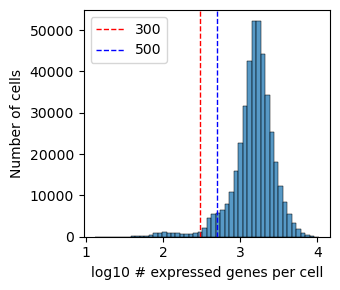

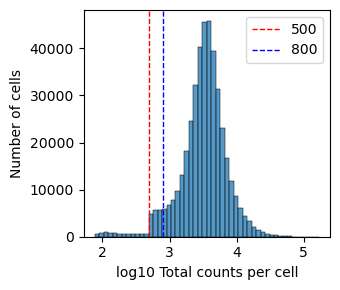

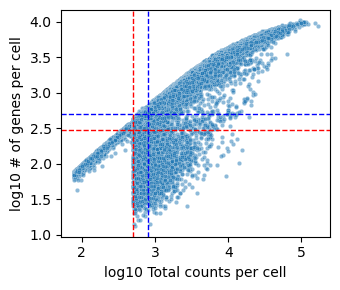

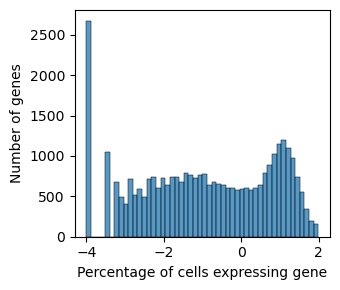

Summary of genes/counts per cell
count    425770.000000
mean       1734.670350
std         953.882539
min          13.000000
25%        1145.000000
50%        1581.000000
75%        2127.000000
max       10445.000000
Name: n_genes_expressed, dtype: float64
count    425770.000000
mean       4223.156250
std        3852.332764
min          77.000000
25%        2217.000000
50%        3408.000000
75%        5002.000000
max      167280.000000
Name: total_counts, dtype: float64
Summary of percent of cells expressing each gene
count    33545.000000
mean         5.171174
std         11.539555
min          0.000000
25%          0.004697
50%          0.120018
75%          4.622918
max         98.836461
Name: pct_cells_expressed, dtype: float64


In [6]:
adata_all.obs['n_genes_expressed'] = (adata_all.X > 0).sum(axis=1).A1  # .A1 flattens sparse matrix result
sns.histplot(np.log10(adata_all.obs['n_genes_expressed']), bins=50, kde=False)
plt.xlabel('log10 # expressed genes per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(300), color='red', linestyle='--', linewidth=1, label='300')
plt.axvline(np.log10(500), color='blue', linestyle='--', linewidth=1, label='500')
plt.legend()
# plt.legend(handles=[line1, line2], loc='upper left')
plt.tight_layout()
plt.show()


adata_all.obs['total_counts'] = adata_all.X.sum(axis=1).A1  # .A1 flattens the sparse matrix row sums
sns.histplot(np.log10(adata_all.obs['total_counts']), bins=50, kde=False)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1, label='500')
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1, label='800')
plt.legend()
plt.tight_layout()
plt.show()

# Scatterplot of log10(total_counts) vs log10(n_genes_expressed)
sns.scatterplot(
    x=np.log10(adata_all.obs['total_counts']),
    y=np.log10(adata_all.obs['n_genes_expressed']),
    alpha=0.5, s=10
)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('log10 # of genes per cell')
plt.axhline(np.log10(300), color='red', linestyle='--', linewidth=1)
plt.axhline(np.log10(500), color='blue', linestyle='--', linewidth=1)
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1)
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

n_cells = adata_all.n_obs
adata_all.var['pct_cells_expressed'] = np.asarray((adata_all.X > 0).sum(axis=0)).ravel() / n_cells * 100
sns.histplot(np.log10(adata_all.var['pct_cells_expressed']+1e-4), bins=50, kde=False)
plt.xlabel('Percentage of cells expressing gene')
plt.ylabel('Number of genes')
plt.tight_layout()
plt.show()

print("Summary of genes/counts per cell")
print(adata_all.obs['n_genes_expressed'].describe())
print(adata_all.obs['total_counts'].describe())

print("Summary of percent of cells expressing each gene")
print(adata_all.var['pct_cells_expressed'].describe())


In [7]:
print(adata_all.shape)
print(type(adata_all))

(425770, 33545)
<class 'anndata._core.anndata.AnnData'>


In [8]:
# ----------------------- filter cells and genes -------------------------
# Filter cells based on number of genes expressed
sc.pp.filter_cells(adata_all, min_genes=300)
min_cells = int(adata_all.n_obs * 0.01)
print(f"Filtering genes expressed in at least {min_cells} cells")
sc.pp.filter_genes(adata_all, min_cells=min_cells)

print(adata_all.shape)
# basic normalisation / log1p 
sc.pp.normalize_total(adata_all, target_sum=5000)
sc.pp.log1p(adata_all)


Filtering genes expressed in at least 4156 cells
(415640, 11952)


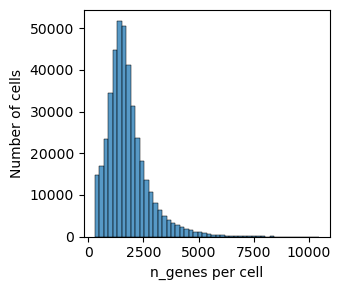

In [9]:
sns.histplot(adata_all.obs['n_genes_expressed'], bins=50, kde=False)
plt.xlabel('n_genes per cell')
plt.ylabel('Number of cells')
plt.tight_layout()
plt.show()

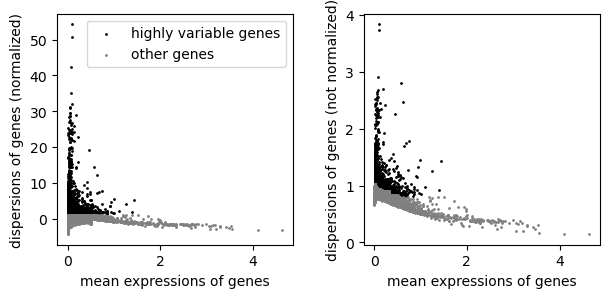

In [10]:
hvg_n         = 2000                           # #HVGs to keep
leiden_res    = 0.6                            # tweak for cluster granularity

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_all, n_top_genes=hvg_n, flavor="cell_ranger")
sc.pl.highly_variable_genes(adata_all)


In [11]:
cd3_genes = [g for g in adata_all.var_names if g.startswith("CD3")]
print(cd3_genes)

additional_genes = ["CD3D", "CD3E"]
genes_to_include = [gene for gene in additional_genes if gene in adata_all.var_names]
print(genes_to_include)

['CD38', 'CD36', 'CD3E', 'CD3D', 'CD3G', 'CD300A', 'CD320', 'CD3EAP', 'CD37']
['CD3D', 'CD3E']


In [12]:
hvg_genes = adata_all.var_names[adata_all.var['highly_variable']].tolist()
if 'CD3D' not in hvg_genes:
    hvg_genes.append('CD3D')
if 'CD3E' not in hvg_genes:
    hvg_genes.append('CD3E')

adata_all = adata_all[:, hvg_genes]
sc.pp.scale(adata_all, max_value=10)
print(adata_all.shape)
# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")


/Users/wsun/anaconda3/envs/CAT/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(415640, 2002)


[0.0275984  0.02598708 0.01549201 0.01396933 0.00649028 0.00610298
 0.00545264 0.00478559 0.00349485 0.00324696 0.00296667 0.00268509
 0.00250265 0.00234945 0.00215192 0.00211146 0.00204403 0.00186114
 0.0017482  0.00167848 0.00157311 0.00154161 0.0015009  0.00148124
 0.00138535 0.00135464 0.00132484 0.00127698 0.00122061 0.00121145
 0.00116474 0.00111781 0.00111493 0.00108593 0.00107529 0.00105315
 0.00103075 0.00102234 0.00100541 0.00099027 0.00097796 0.00096982
 0.00094397 0.0009329  0.00092035 0.00089867 0.00088943 0.00087671
 0.00086748 0.0008575 ]


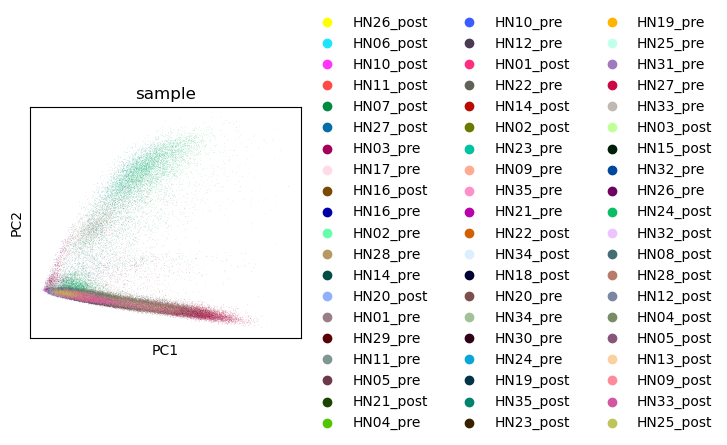

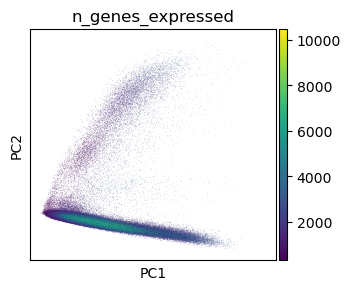

In [13]:
adata_all.uns['pca']['variance_ratio']
print(adata_all.uns['pca']['variance_ratio'])

sc.pl.pca(adata_all, color="sample", use_raw=False)
sc.pl.pca(adata_all, color="n_genes_expressed", use_raw=False)

In [14]:
pc1_values = adata_all.obsm['X_pca'][:, 0]
adata_all.obs['PC1'] = pc1_values
top_pc1_cells = adata_all.obs.sort_values('PC1', ascending=False).head(1000)
top_pc1_samples = top_pc1_cells['sample'].value_counts()
print(top_pc1_samples)


sample
HN27_pre     558
HN26_pre      63
HN11_post     52
HN24_post     41
HN04_post     40
HN12_post     39
HN27_post     26
HN22_post     25
HN11_pre      23
HN03_pre      19
HN13_post     12
HN01_post     10
HN28_post      9
HN33_post      9
HN35_post      9
HN14_post      7
HN10_post      7
HN03_post      6
HN23_pre       6
HN18_post      5
HN28_pre       5
HN05_pre       5
HN04_pre       3
HN10_pre       3
HN14_pre       3
HN19_pre       3
HN32_pre       2
HN23_post      2
HN20_post      2
HN05_post      1
HN09_post      1
HN25_post      1
HN16_pre       1
HN02_pre       1
HN22_pre       1
HN34_post      0
HN20_pre       0
HN07_post      0
HN17_pre       0
HN16_post      0
HN01_pre       0
HN29_pre       0
HN08_post      0
HN32_post      0
HN21_post      0
HN12_pre       0
HN15_post      0
HN02_post      0
HN33_pre       0
HN09_pre       0
HN31_pre       0
HN25_pre       0
HN35_pre       0
HN21_pre       0
HN06_post      0
HN19_post      0
HN24_pre       0
HN30_pre       0
HN34_pr

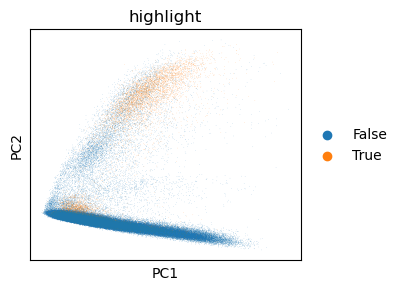

In [15]:
adata_all.obs['highlight'] = (adata_all.obs['sample'] == "HN24_post")
sc.pl.pca(adata_all, color="highlight", use_raw=False)

In [16]:
sc.pp.neighbors(adata_all, n_pcs=50, metric="cosine")
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)

/Users/wsun/anaconda3/envs/CAT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/fk/gk1pvdpx7fz79tx26t0rjc7c0000gp/T/ipykernel_12841/2320544924.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")


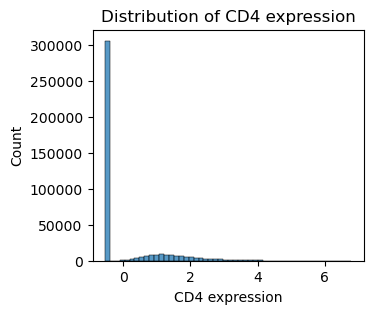

In [17]:
cd4_expr = adata_all[:, 'CD4'].X
if not isinstance(cd4_expr, np.ndarray):
    cd4_expr = cd4_expr.toarray().flatten()
else:
    cd4_expr = cd4_expr.flatten()
sns.histplot(cd4_expr, bins=50)
plt.xlabel('CD4 expression')
plt.title('Distribution of CD4 expression')
plt.show()

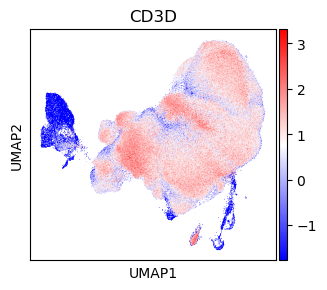

In [18]:
sc.pl.umap(
    adata_all,
    color='CD3D',
    color_map='bwr',
    size=1)


['CD3D', 'CD3E', 'CD4', 'FOXP3', 'CD8A', 'CD8B', 'GZMB', 'NKG7', 'IL7R', 'CCR7', 'SELL']


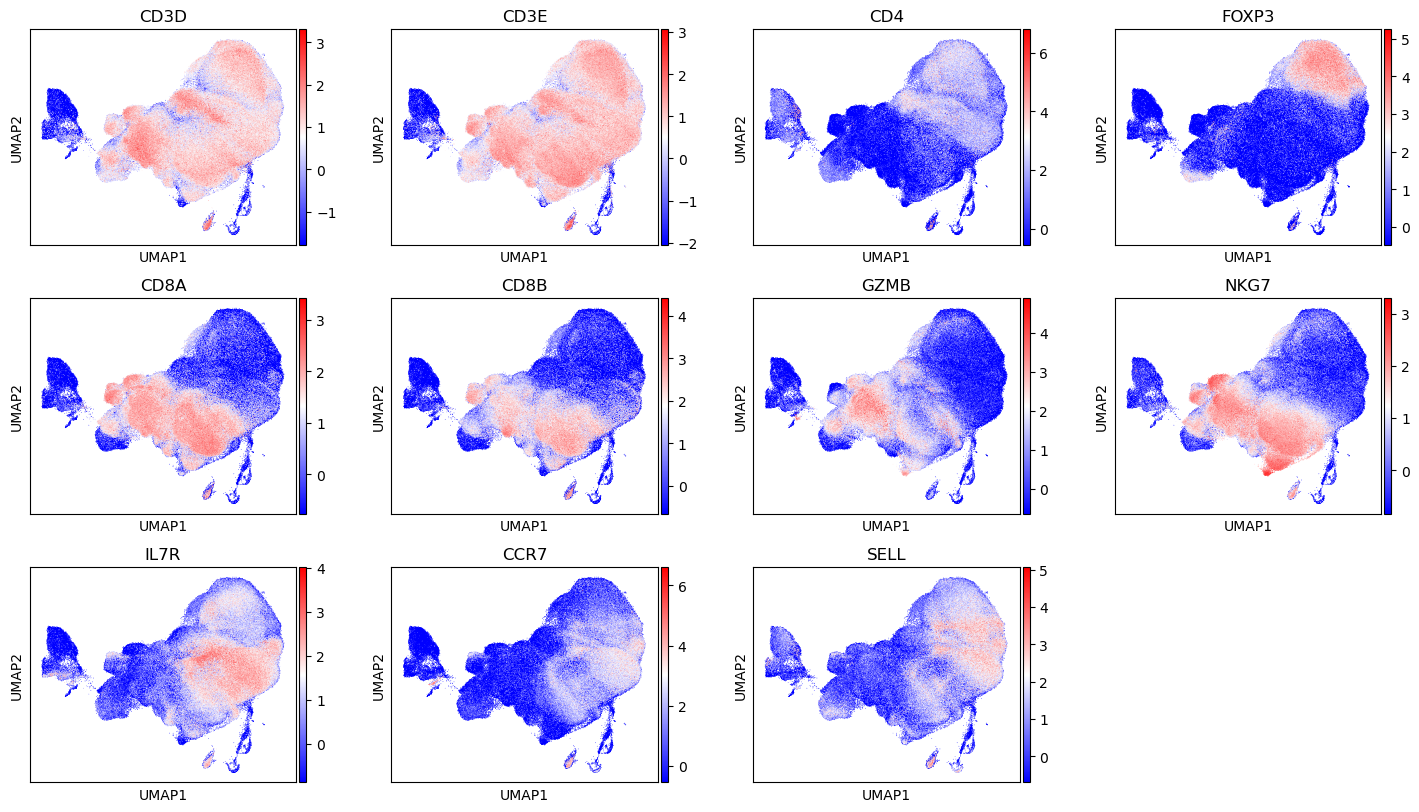

In [19]:
# Flatten the marker gene list
all_marker_genes = ['CD3D', 'CD3E', 'CD4', 'FOXP3', 'CD8A', 'CD8B', 'GZMB', 'NKG7',  'IL7R', 'CCR7', 'SELL']

genes_to_plot = [g for g in all_marker_genes if g in adata_all.var_names]
print(genes_to_plot)

# Plot with 4 columns per row
sc.pl.umap(
    adata_all,
    color=genes_to_plot,
    ncols=4,
    color_map='bwr',
    size=1
)


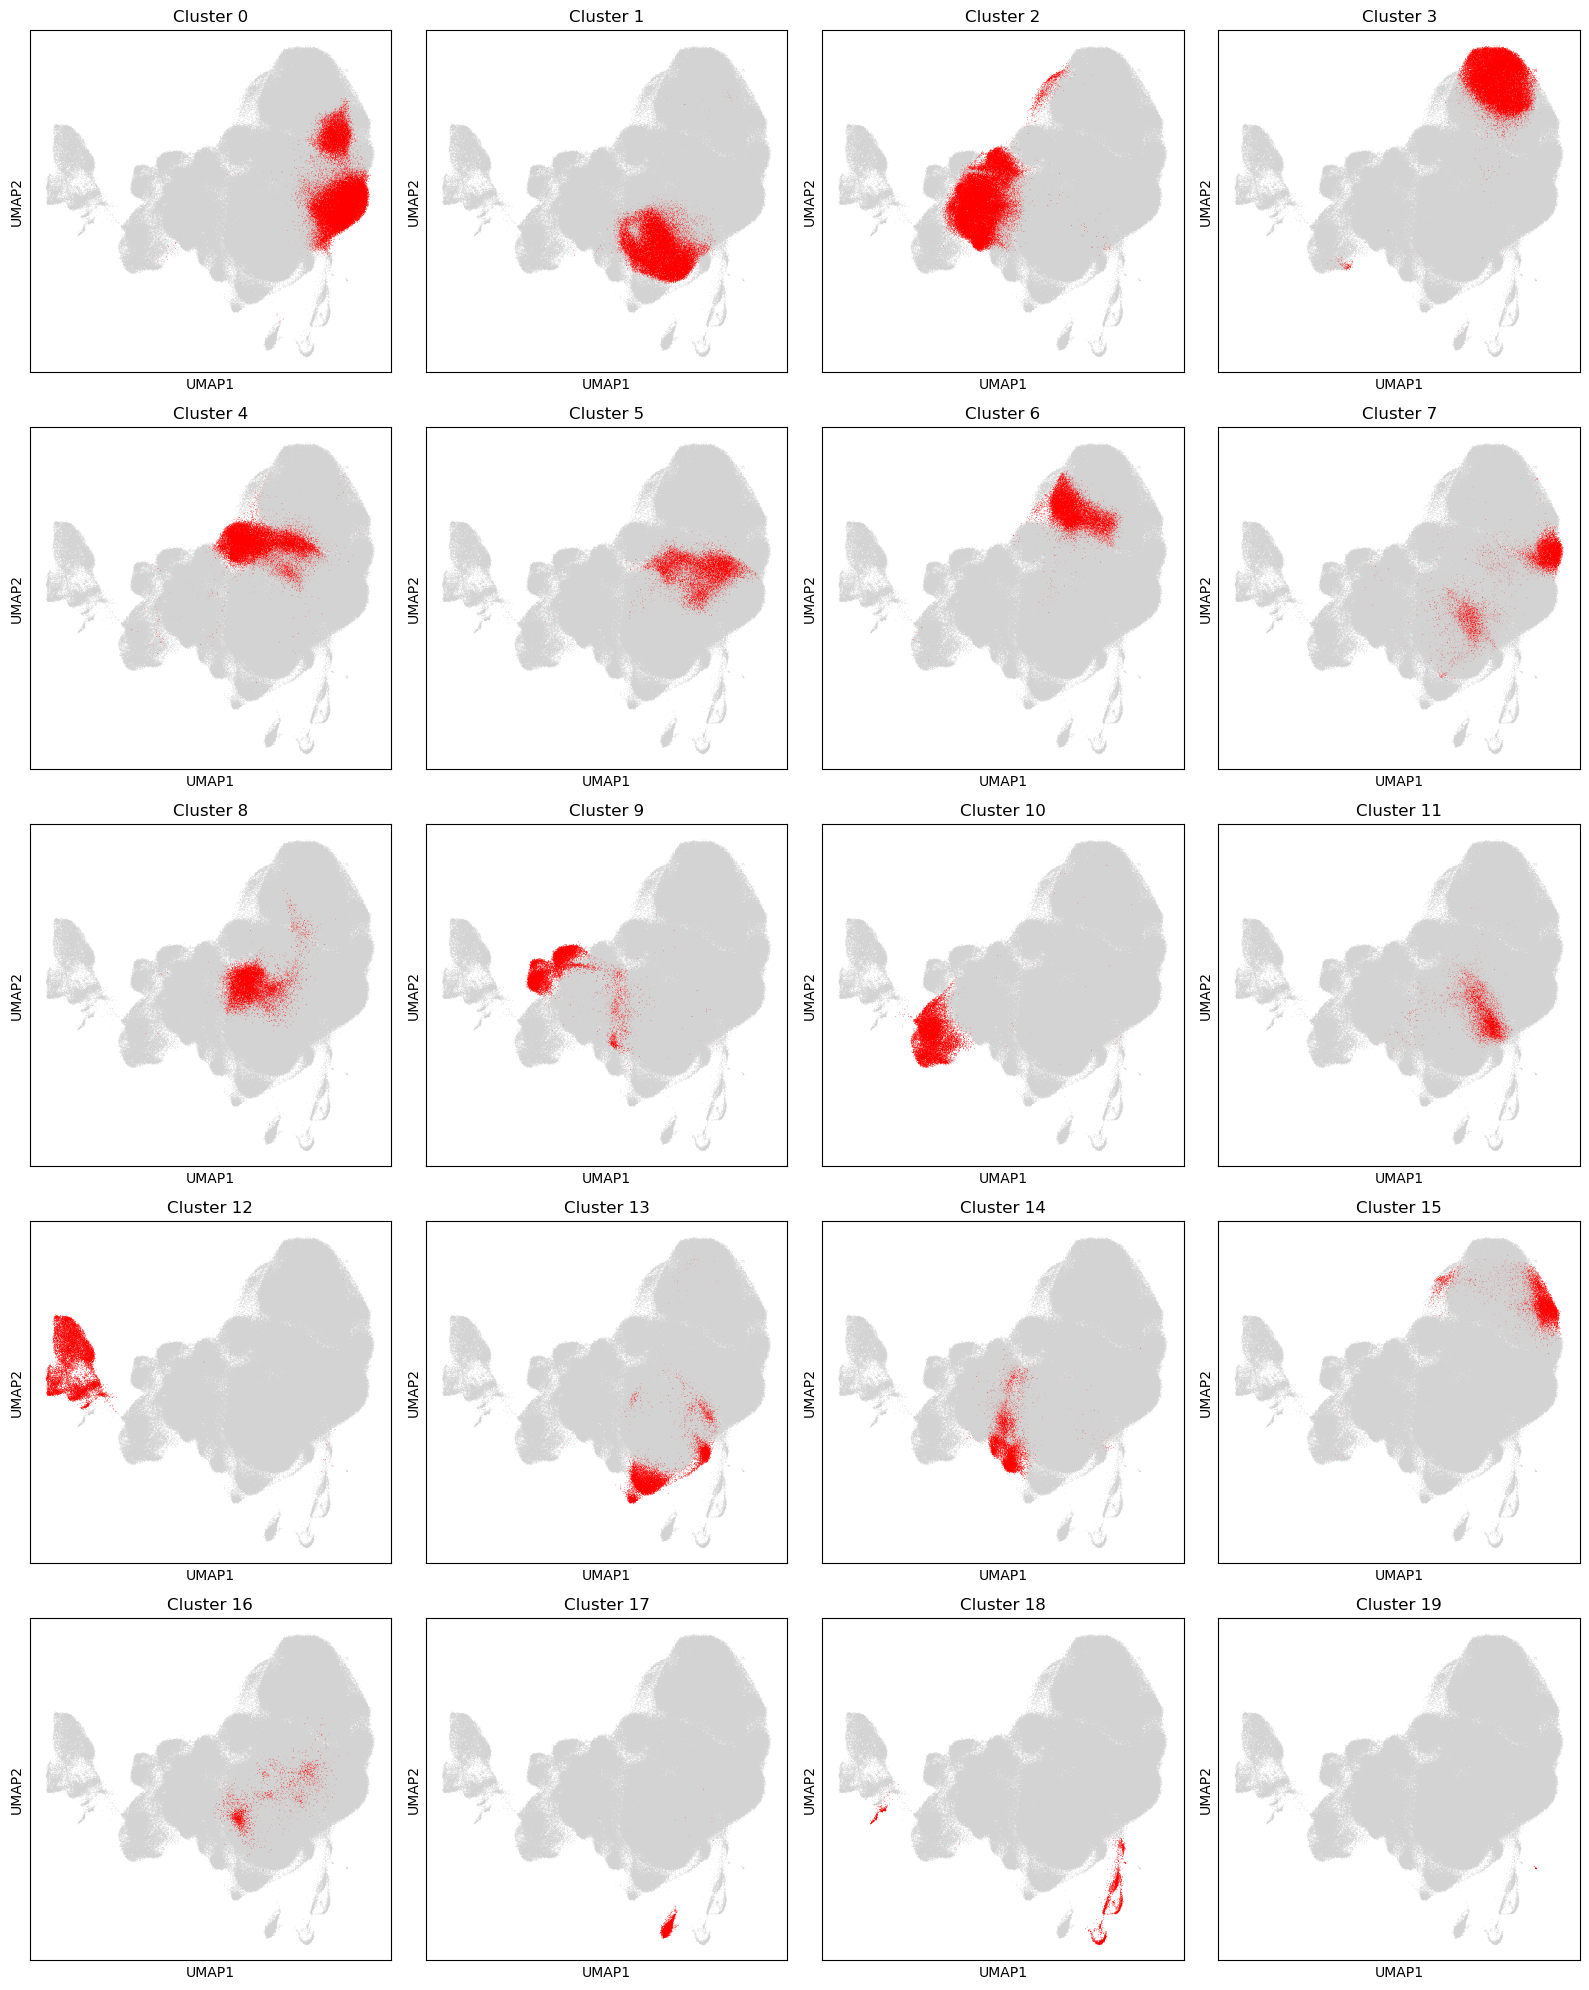

In [25]:
adata_all.obs['cluster'] = adata_all.obs['cluster'].astype(int)
clusters = sorted(adata_all.obs['cluster'].unique())

n = len(clusters)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

for ax, cluster in zip(axes.flat, clusters):
    adata_all.obs['highlight'] = (adata_all.obs['cluster'] == cluster).map({True: 'highlight', False: 'other'})
    
    sc.pl.umap(
        adata_all,
        color='highlight',
        palette={'highlight': 'red', 'other': 'lightgrey'},
        size=1,
        show=False,
        ax=ax,
        title=f"Cluster {cluster}",
        legend_loc=None
    )

# Hide any unused subplots
for ax in axes.flat[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("highlight_clusters_grid.png", dpi=300)
plt.show()

In [22]:
#   marker lists (feel free to expand)
markers = {
    "CD3": ["CD3D", "CD3E"],
    "CD4": ["CD4", "FOXP3"],
    "CD8": ["CD8A", "CD8B"],
}

# -------------------- CD4 / CD8 scores & predictions ----------------------
# per‑cell scores
sc.tl.score_genes(adata_all, gene_list=markers["CD3"], score_name="CD3_score", use_raw =False)
sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score", use_raw =False)
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score", use_raw =False)


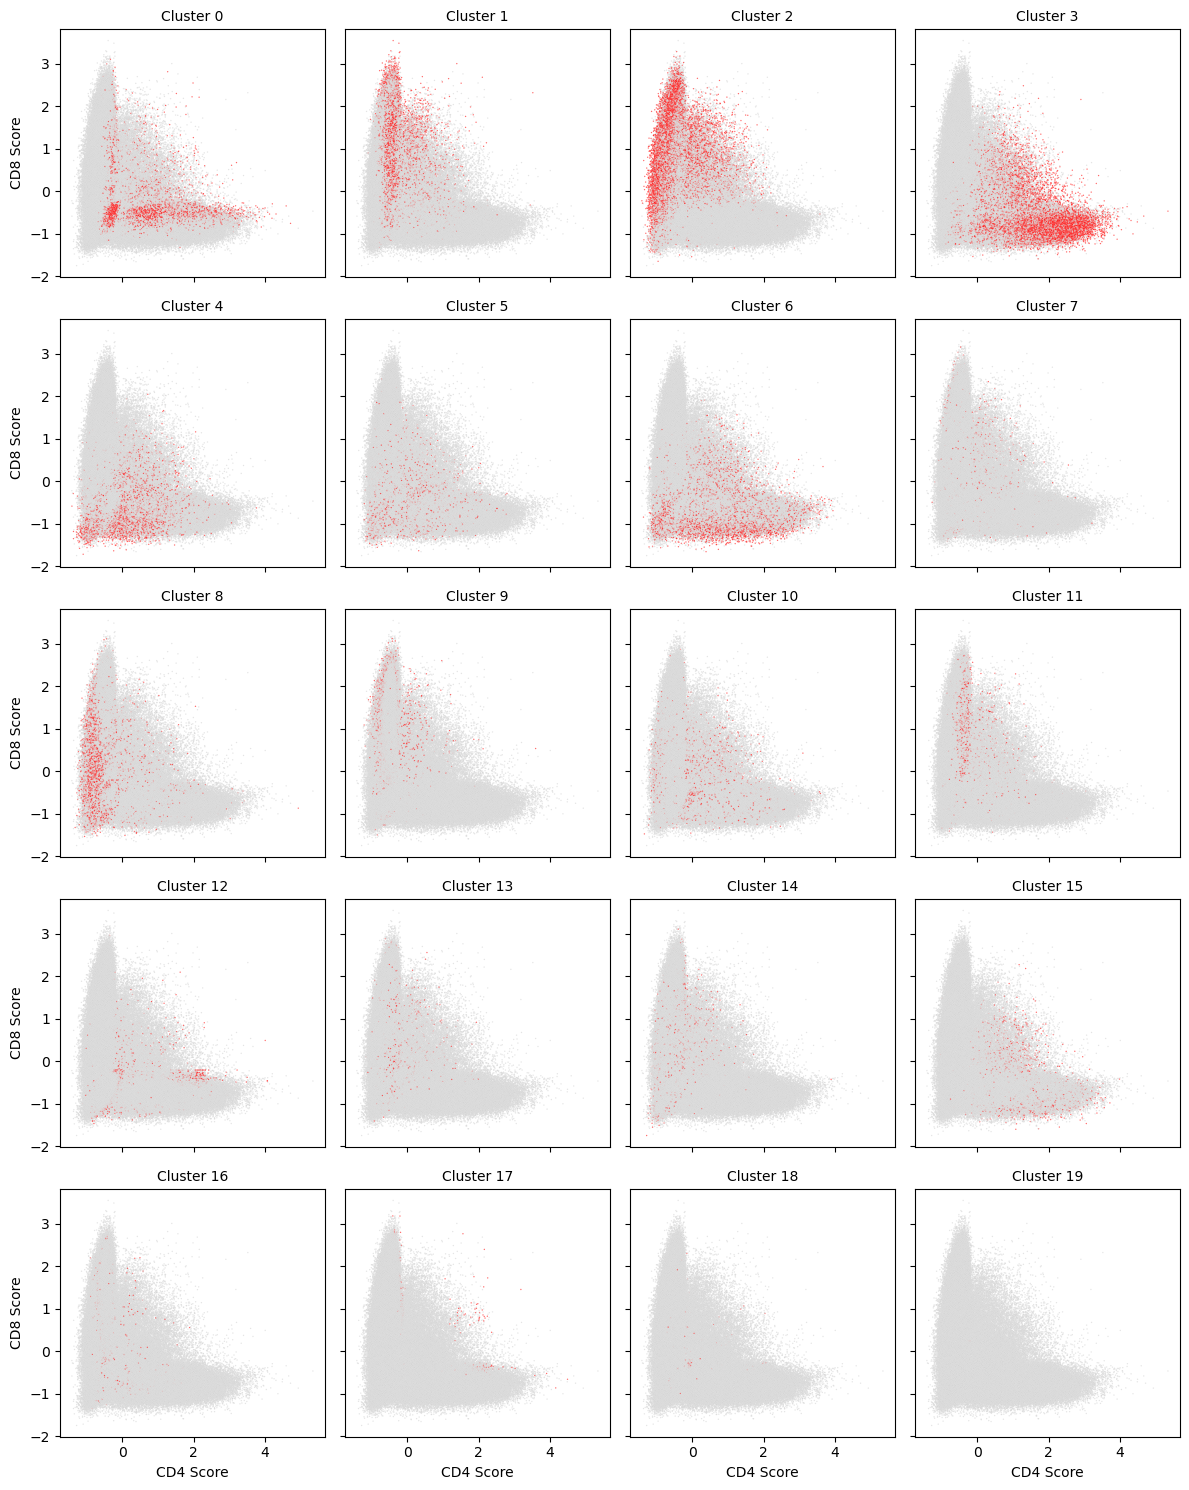

In [23]:
# Ensure cluster is integer and sorted
adata_all.obs['cluster'] = adata_all.obs['cluster'].astype(int)
clusters = sorted(adata_all.obs['cluster'].unique())

# Set grid dimensions
n_clusters = len(clusters)
ncols = 4  # adjust as needed
nrows = (n_clusters + ncols - 1) // ncols

# Create grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), sharex=True, sharey=True)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Plot each cluster highlight
    sns.scatterplot(
        x=adata_all.obs['CD4_score'],
        y=adata_all.obs['CD8_score'],
        hue=(adata_all.obs['cluster'] == cluster),
        palette={True: 'red', False: 'lightgray'},
        alpha=0.6,
        s=1,
        legend=False,
        ax=ax
    )
    ax.set_title(f'Cluster {cluster}', fontsize=10)
    ax.set_xlabel('CD4 Score')
    ax.set_ylabel('CD8 Score')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("cluster_cd4_cd8_grid.png", dpi=300)
plt.show()

In [24]:
# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD3_score", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)

proportion_cd4_gt_cd8 = (
    (adata_all.obs["CD4_score"] > adata_all.obs["CD8_score"])
    .groupby(adata_all.obs["cluster"])
    .mean()
)

clust_means["CD4_gt_CD8_fraction"] = proportion_cd4_gt_cd8

clust_means["predicted_type"] = np.where(
    (clust_means["CD3_score"] > -1.5) & 
    (clust_means["CD4_score"] > 0) & 
    (clust_means["CD8_score"] < 0) & 
    (clust_means["CD4_gt_CD8_fraction"] > 0.6), 
    "CD4", 
    np.where(
        (clust_means["CD3_score"] > -1.5) & 
        (clust_means["CD4_score"] < 0) & 
        (clust_means["CD8_score"] > 0) & 
        (clust_means["CD4_gt_CD8_fraction"] < 0.4), 
        "CD8", 
        "unknown"
    )
)

print(clust_means)

         CD3_score  CD4_score  CD8_score  CD4_gt_CD8_fraction predicted_type
cluster                                                                     
0         0.133162   0.137381  -0.390286             0.871862            CD4
1         0.312263  -0.401080   0.906426             0.173697            CD8
2         0.326580  -0.518454   0.832983             0.084320            CD8
3         0.322413   1.215936  -0.711840             0.978657            CD4
4         0.191010   0.141442  -0.682039             0.918264            CD4
5        -0.476256  -0.115278  -0.498147             0.813149        unknown
6        -0.898413   0.480018  -0.707156             0.904288            CD4
7         0.065974  -0.270675   0.076718             0.538339        unknown
8        -1.072863  -0.501894   0.027098             0.384650            CD8
9         0.424489  -0.540132   1.141632             0.051913            CD8
10       -0.015567  -0.032566   0.023952             0.503129        unknown

In [26]:
# map back to every cell
adata_all.obs["cell_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

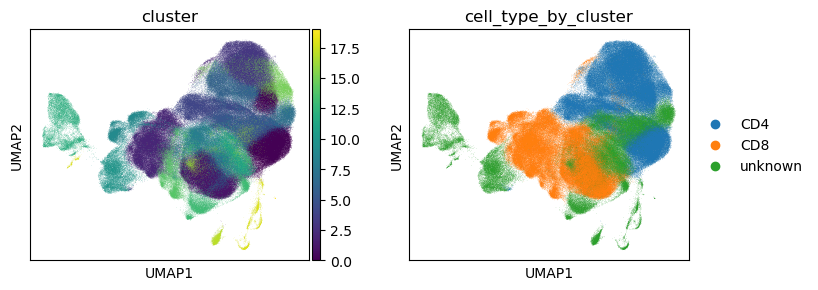

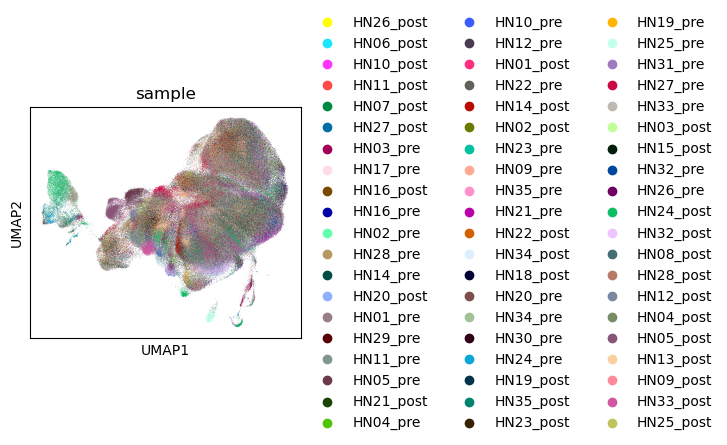

In [27]:
sc.pl.umap(adata_all, color=["cluster", "cell_type_by_cluster"])
sc.pl.umap(adata_all, color=["sample"])


In [28]:
pd.crosstab(adata_all.obs['cluster'], adata_all.obs['cell_type_by_cluster'])

cell_type_by_cluster    CD4    CD8  unknown
cluster                                    
0                     58445      0        0
1                         0  55568        0
2                         0  47545        0
3                     46058      0        0
4                     30109      0        0
5                         0      0    28108
6                     20008      0        0
7                         0      0    19471
8                         0  17863        0
9                         0  13176        0
10                        0      0    12943
11                        0      0    12810
12                        0      0    12604
13                        0      0    11426
14                        0  10442        0
15                     9923      0        0
16                        0      0     3535
17                        0      0     2808
18                        0      0     2774
19                        0      0       24

In [29]:
adata_all.obs

sample  n_genes_expressed  total_counts  \
AAACCTGAGACGACGT-HN26_post  HN26_post                956        1488.0   
AAACCTGAGCGAAGGG-HN26_post  HN26_post               1940        4858.0   
AAACCTGCACAGACTT-HN26_post  HN26_post               1415        2459.0   
AAACCTGCATATGCTG-HN26_post  HN26_post               1666        4031.0   
AAACCTGCATGCATGT-HN26_post  HN26_post               1377        2883.0   
...                               ...                ...           ...   
TTTGGTTGTTTCCACC-HN25_post  HN25_post               3201        9324.0   
TTTGTCAAGACCACGA-HN25_post  HN25_post               1185        2890.0   
TTTGTCATCCACGAAT-HN25_post  HN25_post               1050        3155.0   
TTTGTCATCCAGTATG-HN25_post  HN25_post               1072        2767.0   
TTTGTCATCTACGAGT-HN25_post  HN25_post                886        1748.0   

                            n_genes       PC1 highlight  cluster  CD3_score  \
AAACCTGAGACGACGT-HN26_post      956 -0.617268     other       10  -1.977171   
AAACCTGAGCGAAGGG-HN26_post     1940 -1.505476     other       14   0.622326   
AAACCTGCACAGACTT-HN26_post     1415  4.517384     other        8   0.244896   
AAACCTGCATATGCTG-HN26_post     1666 -0.199830     other        5  -0.948125   
AAACCTGCATGCATGT-HN26_post     1377 -3.989759     other        5   0.432810   
...                             ...       ...       ...      ...        ...   
TTTGGTTGTTTCCACC-HN25_post     3201  1.825201     other        3   0.154496   
TTTGTCAAGACCACGA-HN25_post     1185 -4.717150     other        0  -0.841601   
TTTGTCATCCACGAAT-HN25_post     1050 -7.143737     other        0   0.441661   
TTTGTCATCCAGTATG-HN25_post     1072 -7.164041     other        0   1.298612   
TTTGTCATCTACGAGT-HN25_post      886 -6.365222     other        1   1.100236   

                            CD4_score  CD8_score cell_type_by_cluster  
AAACCTGAGACGACGT-HN26_post   0.605618  -0.638679              unknown  
AAACCTGAGCGAAGGG-HN26_post  -0.543039   0.366773                  CD8  
AAACCTGCACAGACTT-HN26_post  -0.254052  -0.768355                  CD8  
AAACCTGCATATGCTG-HN26_post   0.273469  -0.693413              unknown  
AAACCTGCATGCATGT-HN26_post  -0.301096  -0.571523              unknown  
...                               ...        ...                  ...  
TTTGGTTGTTTCCACC-HN25_post   2.185722  -0.894117                  CD4  
TTTGTCAAGACCACGA-HN25_post  -0.367154  -0.665626                  CD4  
TTTGTCATCCACGAAT-HN25_post  -0.152531  -0.403710                  CD4  
TTTGTCATCCAGTATG-HN25_post   0.856797  -0.594084                  CD4  
TTTGTCATCTACGAGT-HN25_post  -0.369973   0.706060                  CD8  

[415640 rows x 11 columns]

In [31]:
obs_df = adata_all.obs.reset_index()
final_df = obs_df[['index', 'sample', 'n_genes', 'CD3_score', 'CD4_score', 'CD8_score', 'cell_type_by_cluster']]
final_df

index     sample  n_genes  CD3_score  CD4_score  \
0       AAACCTGAGACGACGT-HN26_post  HN26_post      956  -1.977171   0.605618   
1       AAACCTGAGCGAAGGG-HN26_post  HN26_post     1940   0.622326  -0.543039   
2       AAACCTGCACAGACTT-HN26_post  HN26_post     1415   0.244896  -0.254052   
3       AAACCTGCATATGCTG-HN26_post  HN26_post     1666  -0.948125   0.273469   
4       AAACCTGCATGCATGT-HN26_post  HN26_post     1377   0.432810  -0.301096   
...                            ...        ...      ...        ...        ...   
415635  TTTGGTTGTTTCCACC-HN25_post  HN25_post     3201   0.154496   2.185722   
415636  TTTGTCAAGACCACGA-HN25_post  HN25_post     1185  -0.841601  -0.367154   
415637  TTTGTCATCCACGAAT-HN25_post  HN25_post     1050   0.441661  -0.152531   
415638  TTTGTCATCCAGTATG-HN25_post  HN25_post     1072   1.298612   0.856797   
415639  TTTGTCATCTACGAGT-HN25_post  HN25_post      886   1.100236  -0.369973   

        CD8_score cell_type_by_cluster  
0       -0.638679              unknown  
1        0.366773                  CD8  
2       -0.768355                  CD8  
3       -0.693413              unknown  
4       -0.571523              unknown  
...           ...                  ...  
415635  -0.894117                  CD4  
415636  -0.665626                  CD4  
415637  -0.403710                  CD4  
415638  -0.594084                  CD4  
415639   0.706060                  CD8  

[415640 rows x 7 columns]

In [32]:
final_df.to_csv('cell_type.csv',index = False)